## Sea Ice Prediction

In [1]:
from numpy.random import seed
seed(1)

# Parameters
[Papermill parameters](https://papermill.readthedocs.io/en/latest/usage-parameterize.html). These can be overridden
from the papermill command line. We use thse to expose hyperparameters to the MLFlow project.

In [1]:
num_epochs = 25
optimizer = "Adam"

batch_size = 12

# Set this to False to disable MLFlow interactions
USE_MLFLOW = True

## Setup MLFlow

In [3]:
if USE_MLFLOW:
    import mlflow
    import mlflow.keras
    import os
    
    mlflow.set_tracking_uri("https://esip.ml.software.ncsa.illinois.edu")

    # If we are running this notebook interactively then we need to explicitly start the 
    # MLFlow run and log our hyperparameters. If intstead, this has been started from the 
    # MLFlow command line then this will be done for us
    if "MLFLOW_RUN_ID" not in os.environ:
        mlflow.start_run()
        mlflow.log_param("num_epochs", num_epochs)
        
    # MLFlow can instrument Keras and log training data and model for us
    mlflow.keras.autolog()
    

2023/07/13 07:21:52 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


## Initial Setup

## Loading Combined Data 1979- 2021

Features:
'wind_10m', 'specific_humidity', 'LW_down', 'SW_down', 'rainfall', 'snowfall', 'sosaline', 'sst', 't2m', 'surface_pressure','sea_ice_extent'




In [4]:
import os
import math
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Lion, AdamW, Adafactor
from attention import Attention
from keras.layers import Dense, Dropout
from keras.layers import LSTM,TimeDistributed
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
# Map the optimizer name to a class instance
opt_instance = eval(f"{optimizer}()")

In [5]:
data = np.load('../data/monthly_features_1979_Aug2021.npy',allow_pickle=True)
target = np.load('../data/monthly_target_1979_Aug2021.npy',allow_pickle=True)

### Adding a Lag to Y values
Here lag = 1 month


In [6]:
#Adding a lag to monthly targets
lag = 1
data = data[:-lag,:,:]
target = target[lag:]

print(data.shape)
print(target.shape)


(511, 1, 10)
(511,)


## Train Validation Split

LSTM network expects the input data to be provided with a specific array structure in the form of: [samples, time steps, features]. We load the csv file and only retain the feature and target columns. The features and target are stored in separate np arrays.

In [7]:

# Sequential split train:val data in 80:20 sequentially 

LEN_DATA = len(data) #total number of pixels

NUM_TRAIN = LEN_DATA - (24+6) #reserve last 30 months for testing
NUM_VALID = LEN_DATA - NUM_TRAIN

print('LEN_DATA:',LEN_DATA)
print('NUM_TRAIN:',NUM_TRAIN)
print('NUM_VALID:',NUM_VALID)

if USE_MLFLOW:
    mlflow.log_param('LEN_DATA', LEN_DATA)
    mlflow.log_param('NUM_TRAIN', NUM_TRAIN)
    mlflow.log_param('NUM_VALID', NUM_VALID)

x_train = data[0:NUM_TRAIN]
x_valid = data[NUM_TRAIN:]

#split features and labels
y_train=target[:NUM_TRAIN] #target is last column i-e sea-ice
y_valid=target[NUM_TRAIN:] #target is last column i-e sea-ice


LEN_DATA: 511
NUM_TRAIN: 481
NUM_VALID: 30


In [8]:
print('x_train.shape:',x_train.shape)
print('y_train.shape:',y_train.shape)
print('x_valid.shape:',x_valid.shape)
print('y_valid.shape:',y_valid.shape)

x_train.shape: (481, 1, 10)
y_train.shape: (481,)
x_valid.shape: (30, 1, 10)
y_valid.shape: (30,)


## Reshaping Input and Target Features

In [9]:
# convert an array of values into a dataset matrix
def reshape_features(dataset, timesteps=1):
    print(dataset.shape)
    X = dataset.reshape((int(dataset.shape[0]/timesteps)), timesteps, dataset.shape[1])
    return X

## Normalization


In [10]:
# normalize the features

scaler_f = StandardScaler()
x_train = scaler_f.fit_transform(x_train.reshape(-1,10)) #reshaping to 2d for standard scaling
x_valid = scaler_f.transform(x_valid.reshape(-1,10)) #reshaping to 2d for standard scaling

scaler_l = StandardScaler()
y_train = scaler_l.fit_transform(y_train.reshape(-1,1)) #reshaping to 2d for standard scaling
y_valid = scaler_l.transform(y_valid.reshape(-1,1)) #reshaping to 2d for standard scaling


In [11]:
#Reshaping data to 3D for modeling
timesteps = 1
x_train = reshape_features(x_train, timesteps) # reshaping to 3d for model
x_valid = reshape_features(x_valid, timesteps) # reshaping to 3d for model


(481, 10)
(30, 10)


In [12]:
print('x_train.shape:',x_train.shape)
print('y_train.shape:',y_train.shape)
print('x_valid.shape:',x_valid.shape)
print('y_valid.shape:',y_valid.shape)

x_train.shape: (481, 1, 10)
y_train.shape: (481, 1)
x_valid.shape: (30, 1, 10)
y_valid.shape: (30, 1)


## LSTM Network

In [13]:
import numpy as np
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import load_model, Model

timestep = timesteps
features = 10

model_input = Input(shape=(timestep,features))
x = LSTM(64, return_sequences=True)(model_input)
x = Dropout(0.2)(x)
x = LSTM(32, return_sequences=True)(x)
x = LSTM(16, return_sequences=True)(x)
x = LSTM(16, return_sequences=True)(x)
x = Attention(trainable = True)(x)
x = Dropout(0.2)(x)
x = Dense(32)(x)
x = Dense(16)(x)
x = Dense(1)(x)
model = Model(model_input, x)
#model.compile(loss='mae', optimizer='adam')
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 10)]           0         
                                                                 
 lstm (LSTM)                 (None, 1, 64)             19200     
                                                                 
 dropout (Dropout)           (None, 1, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 32)             12416     
                                                                 
 lstm_2 (LSTM)               (None, 1, 16)             3136      
                                                                 
 lstm_3 (LSTM)               (None, 1, 16)             2112      
                                                                 
 attention (Attention)       (None, 128)               4352  

In [14]:
extent = target
print(extent.shape)

(511,)


## Compiling the Network and Fitting Model

In [15]:
#Compiling the network

# For MLFlow, we can create a plot of loss functions by epoch to help us see training 
# performance. Create a Keras callback to handle this
class EpochEndCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if USE_MLFLOW:
            mlflow.log_metric(key="loss", value=logs['loss'], step=epoch)
            mlflow.log_metric(key="val_loss", value=logs['val_loss'], step=epoch)


model.compile(loss='mean_squared_error', optimizer=opt_instance)
checkpoint_path='./testmodel.h5'
keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=60, mode='min', min_delta=0.001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min'),
      EpochEndCallback()]


In [16]:
history=model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, verbose=2, validation_split =0.3, shuffle=True,callbacks=keras_callbacks)

Epoch 1/25


2023-07-12 16:50:11.864168: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2300 num_cores: 8 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 524288 l3_cache_size: 8388608 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-07-12 16:50:13.786287: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2300 num_cores: 8 environment { key: "cpu_instruction_set" value: "AVX SSE, 

28/28 - 8s - loss: 0.8002 - val_loss: 0.7334 - 8s/epoch - 281ms/step
Epoch 2/25
28/28 - 0s - loss: 0.1201 - val_loss: 0.1464 - 401ms/epoch - 14ms/step
Epoch 3/25
28/28 - 1s - loss: 0.0429 - val_loss: 0.0971 - 512ms/epoch - 18ms/step
Epoch 4/25
28/28 - 0s - loss: 0.0262 - val_loss: 0.0712 - 392ms/epoch - 14ms/step
Epoch 5/25
28/28 - 0s - loss: 0.0274 - val_loss: 0.0450 - 364ms/epoch - 13ms/step
Epoch 6/25
28/28 - 0s - loss: 0.0277 - val_loss: 0.0634 - 434ms/epoch - 15ms/step
Epoch 7/25
28/28 - 0s - loss: 0.0257 - val_loss: 0.0366 - 428ms/epoch - 15ms/step
Epoch 8/25
28/28 - 0s - loss: 0.0247 - val_loss: 0.0631 - 441ms/epoch - 16ms/step
Epoch 9/25
28/28 - 0s - loss: 0.0252 - val_loss: 0.0395 - 352ms/epoch - 13ms/step
Epoch 10/25
28/28 - 0s - loss: 0.0250 - val_loss: 0.0552 - 415ms/epoch - 15ms/step
Epoch 11/25
28/28 - 0s - loss: 0.0241 - val_loss: 0.0321 - 336ms/epoch - 12ms/step
Epoch 12/25
28/28 - 0s - loss: 0.0194 - val_loss: 0.0462 - 313ms/epoch - 11ms/step
Epoch 13/25
28/28 - 0s - l

2023-07-12 16:50:24.604572: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2300 num_cores: 8 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 524288 l3_cache_size: 8388608 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


1/1 [==============================] - 1s 1s/step
INFO:tensorflow:Assets written to: /var/folders/h2/vg8rztjd7bl2d6rcdc6mdfth0000gp/T/tmpqn53ywvz/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/h2/vg8rztjd7bl2d6rcdc6mdfth0000gp/T/tmpqn53ywvz/model/data/model/assets
2023/07/12 16:50:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/bengal1/.mlflow/envs/mlflow-1f83dc0f37347b2d70cd48c781b33dfcaaa216df/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


## Model Predictions

In [17]:
trainPred = model.predict(x_train)
testPred = model.predict(x_valid)

1/1 [==============================] - 0s 18ms/step


In [18]:
print(testPred.shape)
print(trainPred.shape)

(30, 1)
(481, 1)


In [19]:
#Reverting data back to 2D from 3D
x_valid_t = x_valid.reshape((x_valid.shape[0], x_valid.shape[2]))
print(x_valid_t.shape)
print(testPred.shape)

(30, 10)
(30, 1)


In [20]:
# invert scaling for forecasted values 

inv_testPred = scaler_l.inverse_transform(testPred)
print(inv_testPred[1])

# invert scaling for actual values

inv_y_valid = scaler_l.inverse_transform(y_valid)
print(inv_y_valid[1])


[14466568.]
[13525194.]


In [21]:
# calculate RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(inv_y_valid, inv_testPred))
print('Test RMSE: %.3f' % rmse)

if USE_MLFLOW:
    mlflow.log_metric(key="test_rmse", value=rmse)


Test RMSE: 896724.996


In [22]:
# calculate Normalized RMSE
y_max = inv_y_valid.max()
y_min = inv_y_valid.min()
nrmse = rmse /(inv_y_valid.mean()) 
print('Test NRMSE:', nrmse)

if USE_MLFLOW:
    mlflow.log_metric(key="test_nrmse", value=nrmse)

Test NRMSE: 0.08539546518607889


In [23]:
# calculate R-square
from sklearn.metrics import r2_score
from math import sqrt

r_sq = r2_score(inv_y_valid, inv_testPred)
print('Test R_Square: %.3f' % r_sq)
if USE_MLFLOW:
    mlflow.log_metric(key="test_r2", value=r_sq)

Test R_Square: 0.937


## Plotting

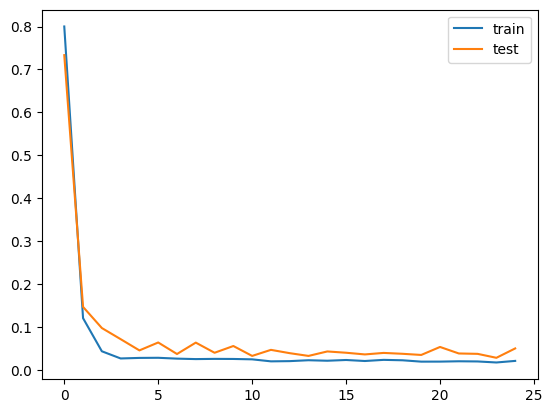

In [24]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


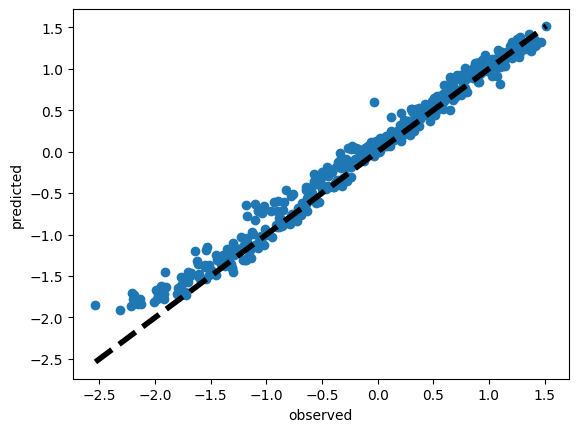

In [25]:
fig, ax = plt.subplots()
ax.scatter(y_train,trainPred)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('observed')
ax.set_ylabel('predicted')
plt.show()

if USE_MLFLOW:
    mlflow.log_figure(fig, "train_prediction.png")


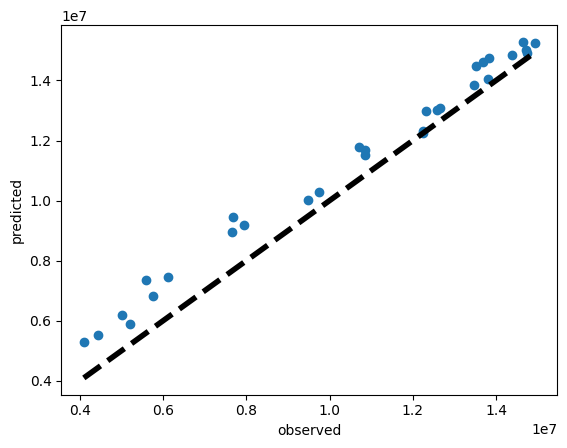

In [26]:
fig, ax = plt.subplots()
ax.scatter(inv_y_valid,inv_testPred) #[:,:,6]
ax.plot([inv_y_valid.min(), inv_y_valid.max()], [inv_y_valid.min(), inv_y_valid.max()], 'k--', lw=4)
ax.set_xlabel('observed')
ax.set_ylabel('predicted')
#plt.savefig('test_prediction.png',bbox_inches='tight',dpi=1200)
plt.show()

if USE_MLFLOW:
    mlflow.log_figure(fig, "test_prediction.png")

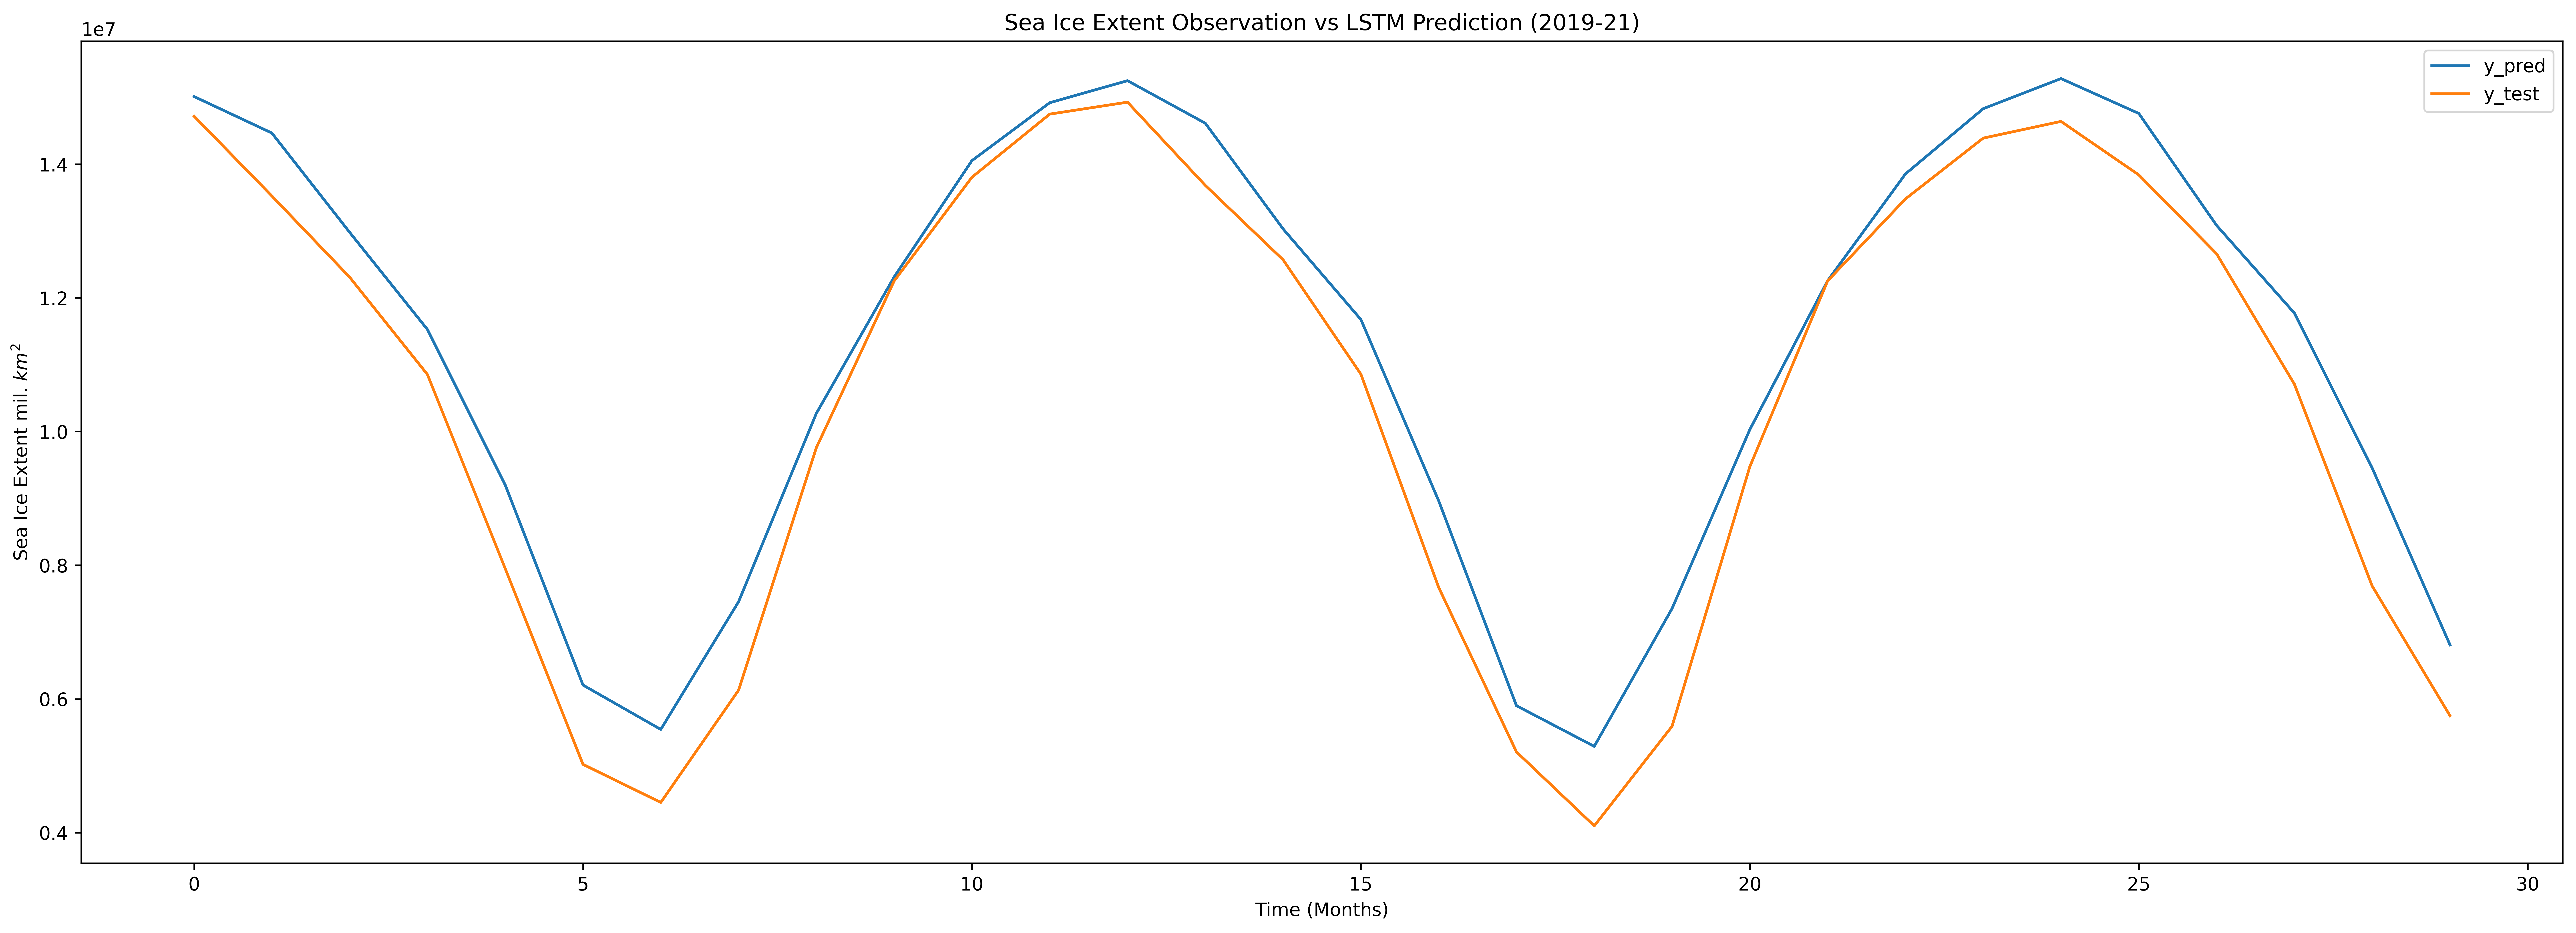

In [30]:
from matplotlib import pyplot
fig, ax= plt.subplots(figsize=(24, 8),dpi = 600)
pyplot.plot(inv_testPred)
pyplot.plot(inv_y_valid)
plt.legend(['y_pred','y_test'])
plt.title("Sea Ice Extent Observation vs LSTM Prediction (2019-21)")
ax.set_xlabel("Time (Months)")
ax.set_ylabel(r"Sea Ice Extent mil. $km^2$")
pyplot.show()
fig.savefig('Time_series_sea_ice_extent_trend_1979_2021_lstm.png', dpi=600)


In [28]:
if USE_MLFLOW:
    mlflow.end_run()